In [1]:
!pip install fbprophet

In [2]:
import warnings
from sklearn.metrics import mean_absolute_error
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import seaborn as sns
sns.set(style="white") #white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.layers import Bidirectional
import re
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error
from math import sqrt

In [3]:
Pop = pd.read_csv("/content/TM.csv")
Pop=Pop.iloc[pd.to_datetime(Pop.Date.astype(str)).argsort()]
Pop

,Date,prix moyen au kg,Production quantité \ntonne(s),Température minimale en °C,Température maximale en °C,précipitations en mm,Ensoleillement en min,Rafales (vitesse du vent) en km/h
354,01/08/12,1.30,0.20,11.8,28.0,0.4,445,44.4
333,01/10/12,1.10,0.20,3.5,19.1,0.8,536,40.7
332,02/10/12,1.10,0.20,12.8,18.8,0.2,121,38.9
353,03/08/12,1.25,0.30,12.0,24.1,0.4,330,42.8
342,04/09/12,1.10,0.40,12.8,25.7,0.0,672,37.0
...,...,...,...,...,...,...,...,...
388,11/09/20,1.75,0.50,14.1,28.2,0.0,552,29.5
19,11/09/20,1.05,0.50,14.1,28.2,0.0,552,29.5
373,19/11/20,1.80,0.05,5.8,11.5,0.0,352,61.2
372,20/11/20,1.50,0.10,-0.1,10.6,0.0,297,26.3


**Pour le prix**

In [4]:
dfP = Pop[["Date","prix moyen au kg"]]
dfP

,Date,prix moyen au kg
354,01/08/12,1.30
333,01/10/12,1.10
332,02/10/12,1.10
353,03/08/12,1.25
342,04/09/12,1.10
...,...,...
388,11/09/20,1.75
19,11/09/20,1.05
373,19/11/20,1.80
372,20/11/20,1.50


In [5]:
dfP['ds'] = pd.to_datetime(dfP['Date'],infer_datetime_format=True, dayfirst= True)
dfP['y'] = dfP['prix moyen au kg']
dfP = dfP.drop(["Date","prix moyen au kg"], axis=1)
dfP

,ds,y
354,2012-08-01,1.30
333,2012-10-01,1.10
332,2012-10-02,1.10
353,2012-08-03,1.25
342,2012-09-04,1.10
...,...,...
388,2020-09-11,1.75
19,2020-09-11,1.05
373,2020-11-19,1.80
372,2020-11-20,1.50


In [6]:
from fbprophet import Prophet
m1 = Prophet(daily_seasonality=True)
m1.fit(dfP)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [7]:
future1 = m1.make_future_dataframe(periods=7, freq='D')
predictions=m1.predict(future1)

In [8]:
predictions[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
400,2021-06-22,1.681639,1.421257,1.953701
401,2021-06-23,1.660132,1.414092,1.903768
402,2021-06-24,1.676705,1.420957,1.912689
403,2021-06-25,1.671665,1.434861,1.928448
404,2021-06-26,1.708716,1.474288,1.948826
405,2021-06-27,1.705565,1.467525,1.944115
406,2021-06-28,1.625655,1.392438,1.873524


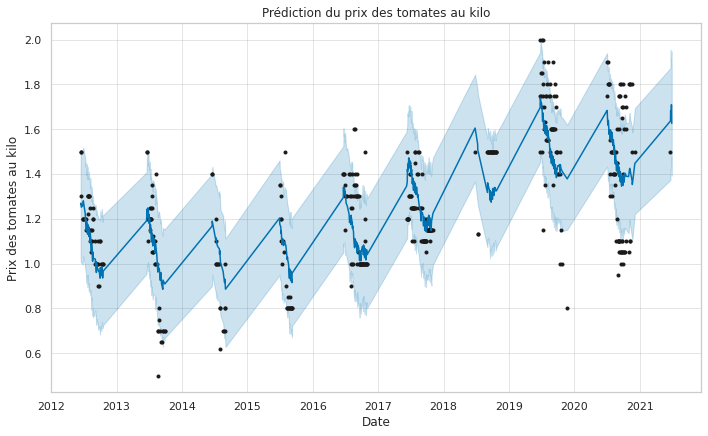

In [9]:
m1.plot(predictions)
plt.title("Prédiction du prix des tomates au kilo")
plt.xlabel("Date")
plt.ylabel("Prix des tomates au kilo")
plt.show()

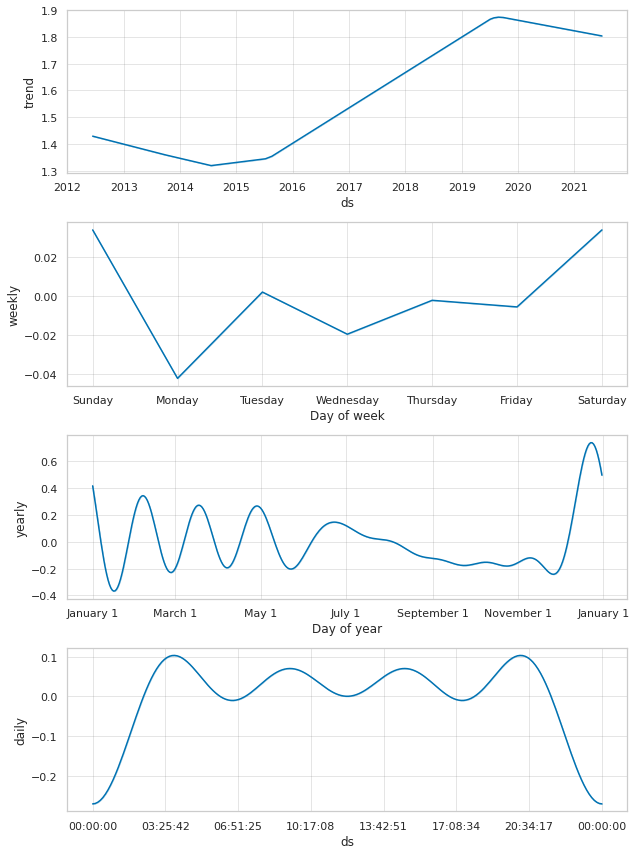

In [10]:
m1.plot_components(predictions)
plt.show()

In [11]:
metric_df = predictions.set_index('ds')[['yhat']].join(dfP.set_index('ds').y).reset_index()
metric_df

,ds,yhat,y
0,2012-06-14,1.263972,1.5
1,2012-06-15,1.269332,1.5
2,2012-06-18,1.251635,1.3
3,2012-06-25,1.257881,1.2
4,2012-06-29,1.279921,1.2
...,...,...,...
426,2021-06-24,1.676705,NaN
427,2021-06-25,1.671665,NaN
428,2021-06-26,1.708716,NaN
429,2021-06-27,1.705565,NaN


In [12]:
metric_df.dropna(inplace=True)
metric_df.tail()

,ds,yhat,y
419,2020-11-06,1.424749,1.1
420,2020-11-19,1.367644,1.8
421,2020-11-20,1.352500,1.5
422,2020-12-04,1.446576,1.5
423,2021-06-21,1.636326,1.5


In [13]:
from sklearn.metrics import mean_squared_error, r2_score
R2P = r2_score(metric_df.y, metric_df.yhat)
R2P

0.5579023916956132

In [14]:
from math import sqrt

rmseP =sqrt(mean_squared_error(metric_df.y, metric_df.yhat))
print(rmseP)

0.19143119371940867


In [15]:
mean_absolute_error(metric_df.y, metric_df.yhat)

0.15155300789916823

**Pour la production**

In [16]:
dfPo = Pop[["Date","Production quantité \ntonne(s)"]]
dfPo

,Date,Production quantité \ntonne(s)
354,01/08/12,0.20
333,01/10/12,0.20
332,02/10/12,0.20
353,03/08/12,0.30
342,04/09/12,0.40
...,...,...
388,11/09/20,0.50
19,11/09/20,0.50
373,19/11/20,0.05
372,20/11/20,0.10


In [17]:
dfPo['ds'] = pd.to_datetime(dfPo['Date'],infer_datetime_format=True, dayfirst= True)
dfPo['y'] = dfPo['Production quantité \ntonne(s)']
dfPo = dfPo.drop(["Date","Production quantité \ntonne(s)"], axis=1)
dfPo

,ds,y
354,2012-08-01,0.20
333,2012-10-01,0.20
332,2012-10-02,0.20
353,2012-08-03,0.30
342,2012-09-04,0.40
...,...,...
388,2020-09-11,0.50
19,2020-09-11,0.50
373,2020-11-19,0.05
372,2020-11-20,0.10


In [18]:
m2 = Prophet(daily_seasonality=True)
m2.fit(dfPo)

In [19]:
future2 = m2.make_future_dataframe(periods=7, freq='D')
predictions2=m2.predict(future2)

In [20]:
predictions2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
400,2021-06-22,-0.395465,-1.264791,0.437323
401,2021-06-23,-0.154134,-0.965172,0.693994
402,2021-06-24,0.368556,-0.511707,1.242415
403,2021-06-25,-0.010952,-0.861060,0.894660
404,2021-06-26,0.026806,-0.807915,0.856384
405,2021-06-27,0.072476,-0.808203,0.883991
406,2021-06-28,0.364407,-0.458927,1.220844


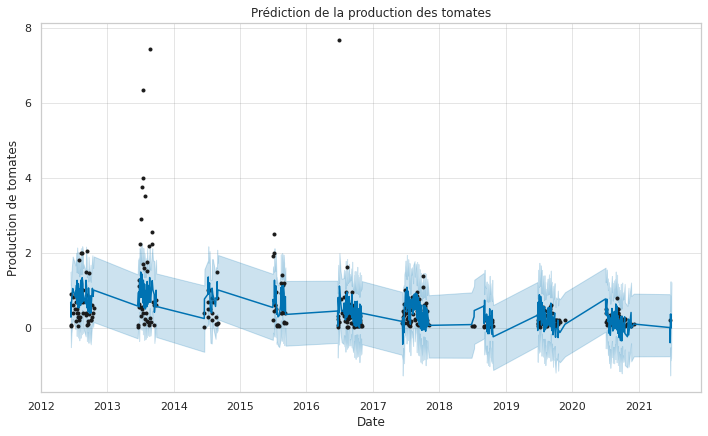

In [21]:
m2.plot(predictions2)
plt.title("Prédiction de la production des tomates")
plt.xlabel("Date")
plt.ylabel("Production de tomates")
plt.show()

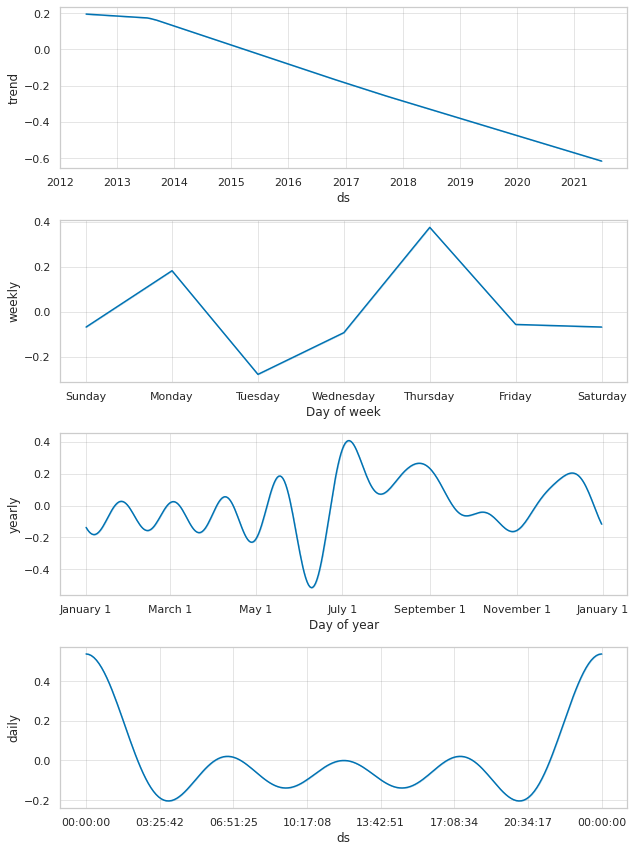

In [22]:
m2.plot_components(predictions2)
plt.show()

In [23]:
metric_df2 = predictions2.set_index('ds')[['yhat']].join(dfPo.set_index('ds').y).reset_index()
metric_df2

,ds,yhat,y
0,2012-06-14,0.681359,0.06
1,2012-06-15,0.286778,0.07
2,2012-06-18,0.665586,0.90
3,2012-06-25,1.049108,0.83
4,2012-06-29,0.980054,0.60
...,...,...,...
426,2021-06-24,0.368556,NaN
427,2021-06-25,-0.010952,NaN
428,2021-06-26,0.026806,NaN
429,2021-06-27,0.072476,NaN


In [24]:
metric_df2.dropna(inplace=True)
metric_df2.tail()

,ds,yhat,y
419,2020-11-06,-0.186811,0.10
420,2020-11-19,0.411165,0.05
421,2020-11-20,-0.009705,0.10
422,2020-12-04,0.103690,0.10
423,2021-06-21,0.009033,0.20


In [25]:
R2Po = r2_score(metric_df2.y, metric_df2.yhat)
R2Po

0.2681334345184202

In [26]:
rmsePo =sqrt(mean_squared_error(metric_df2.y, metric_df2.yhat))
print(rmsePo)

0.6637481153894874


In [27]:
mean_absolute_error(metric_df2.y, metric_df2.yhat)

0.34995375001023926

**Météo future**

In [28]:
#la température minimale

dfTm = Pop[["Date","Température minimale en °C"]]
dfTm

,Date,Température minimale en °C
354,01/08/12,11.8
333,01/10/12,3.5
332,02/10/12,12.8
353,03/08/12,12.0
342,04/09/12,12.8
...,...,...
388,11/09/20,14.1
19,11/09/20,14.1
373,19/11/20,5.8
372,20/11/20,-0.1


In [29]:
dfTm['ds'] = pd.to_datetime(dfTm['Date'],infer_datetime_format=True, dayfirst= True)
dfTm['y'] = dfTm['Température minimale en °C']
dfTm = dfTm.drop(["Date","Température minimale en °C"], axis=1)
dfTm

,ds,y
354,2012-08-01,11.8
333,2012-10-01,3.5
332,2012-10-02,12.8
353,2012-08-03,12.0
342,2012-09-04,12.8
...,...,...
388,2020-09-11,14.1
19,2020-09-11,14.1
373,2020-11-19,5.8
372,2020-11-20,-0.1


In [30]:
m3 = Prophet(daily_seasonality=True)
m3.fit(dfTm)

In [31]:
future3 = m3.make_future_dataframe(periods=7, freq='D')
predictions3=m3.predict(future3)

In [32]:
predictions3[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
400,2021-06-22,15.797543,11.695547,19.881715
401,2021-06-23,16.191901,12.204559,20.064569
402,2021-06-24,16.025044,11.983263,19.898164
403,2021-06-25,15.519628,11.068751,19.452719
404,2021-06-26,15.158861,11.299209,18.897081
405,2021-06-27,14.871623,10.734759,18.853293
406,2021-06-28,13.794978,9.433304,17.831418


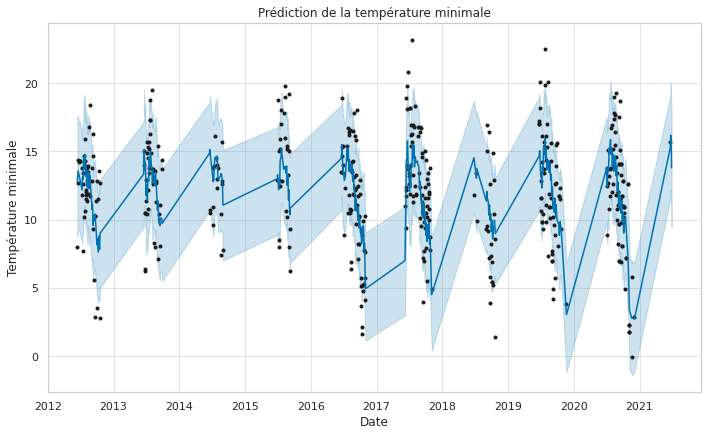

In [33]:
m3.plot(predictions3)
plt.title("Prédiction de la température minimale")
plt.xlabel("Date")
plt.ylabel("Température minimale")
plt.show()

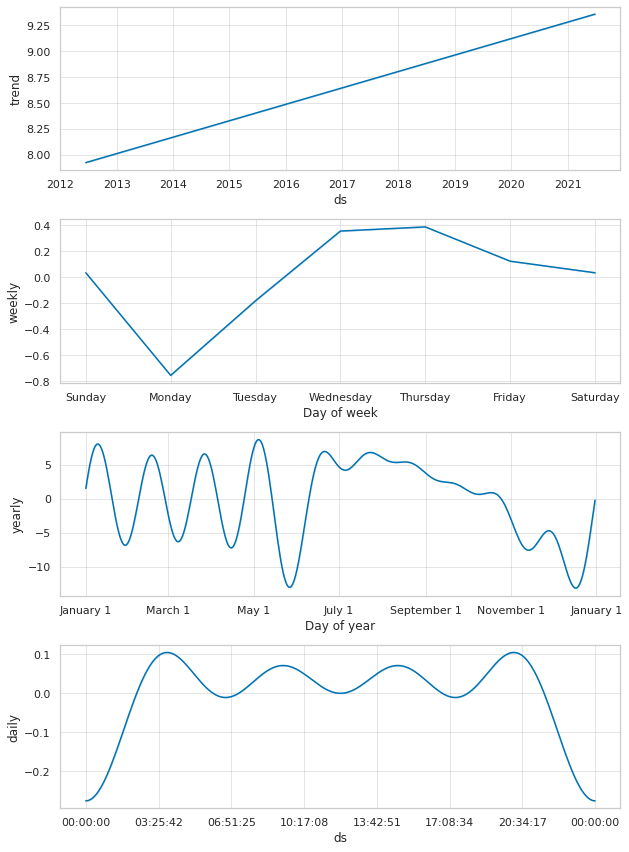

In [34]:
m3.plot_components(predictions3)
plt.show()

In [35]:
#température maximale

dfTM = Pop[["Date","Température maximale en °C"]]
dfTM

,Date,Température maximale en °C
354,01/08/12,28.0
333,01/10/12,19.1
332,02/10/12,18.8
353,03/08/12,24.1
342,04/09/12,25.7
...,...,...
388,11/09/20,28.2
19,11/09/20,28.2
373,19/11/20,11.5
372,20/11/20,10.6


In [36]:
dfTM['ds'] = pd.to_datetime(dfTM['Date'],infer_datetime_format=True, dayfirst= True)
dfTM['y'] = dfTM['Température maximale en °C']
dfTM = dfTM.drop(["Date","Température maximale en °C"], axis=1)
dfTM

,ds,y
354,2012-08-01,28.0
333,2012-10-01,19.1
332,2012-10-02,18.8
353,2012-08-03,24.1
342,2012-09-04,25.7
...,...,...
388,2020-09-11,28.2
19,2020-09-11,28.2
373,2020-11-19,11.5
372,2020-11-20,10.6


In [37]:
m4 = Prophet(daily_seasonality=True)
m4.fit(dfTM)

In [38]:
future4 = m4.make_future_dataframe(periods=7, freq='D')
predictions4=m4.predict(future4)

In [39]:
predictions4[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
400,2021-06-22,28.764415,23.438880,33.830952
401,2021-06-23,29.345108,24.051337,34.684305
402,2021-06-24,28.547911,23.104285,34.310807
403,2021-06-25,28.149123,22.807497,33.539040
404,2021-06-26,28.786451,23.198262,34.549776
405,2021-06-27,28.599506,22.975589,34.503243
406,2021-06-28,27.616413,22.047250,33.054422


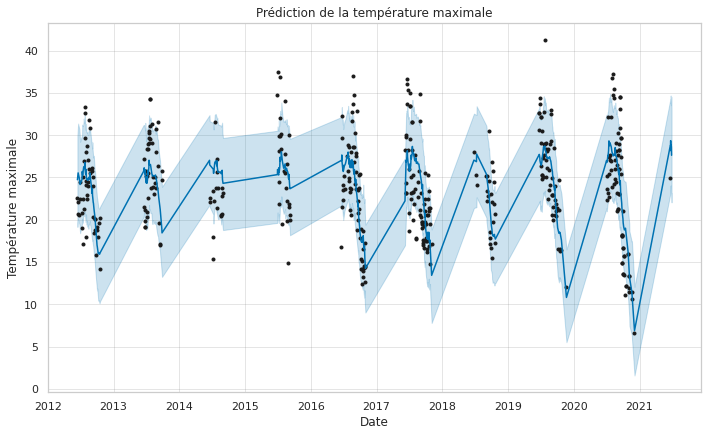

In [40]:
m4.plot(predictions4)
plt.title("Prédiction de la température maximale")
plt.xlabel("Date")
plt.ylabel("Température maximale")
plt.show()

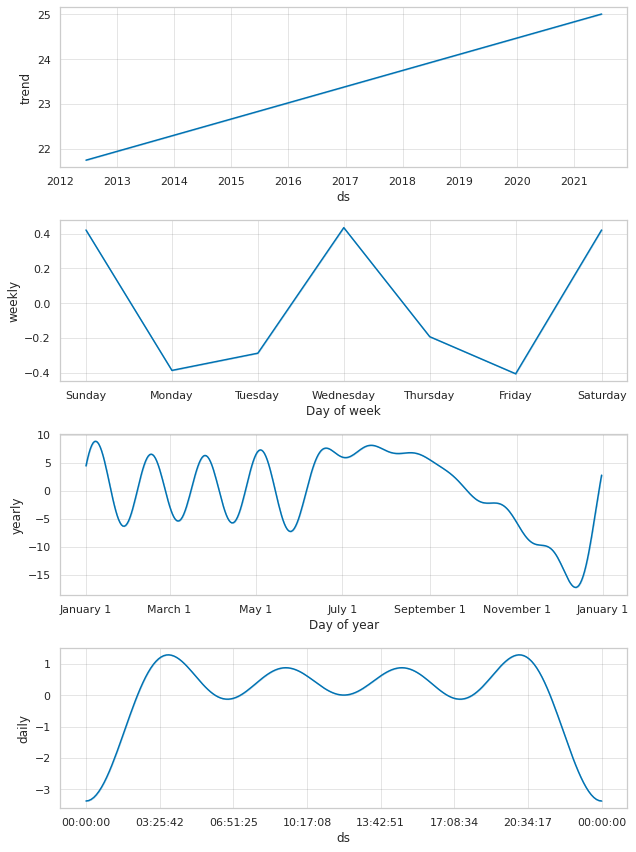

In [41]:
m4.plot_components(predictions4)
plt.show()

In [42]:
# les précipitations

dfp = Pop[["Date","précipitations en mm"]]
dfp

,Date,précipitations en mm
354,01/08/12,0.4
333,01/10/12,0.8
332,02/10/12,0.2
353,03/08/12,0.4
342,04/09/12,0.0
...,...,...
388,11/09/20,0.0
19,11/09/20,0.0
373,19/11/20,0.0
372,20/11/20,0.0


In [43]:
dfp['ds'] = pd.to_datetime(dfp['Date'],infer_datetime_format=True, dayfirst= True)
dfp['y'] = dfp['précipitations en mm']
dfp = dfp.drop(["Date","précipitations en mm"], axis=1)
dfp

,ds,y
354,2012-08-01,0.4
333,2012-10-01,0.8
332,2012-10-02,0.2
353,2012-08-03,0.4
342,2012-09-04,0.0
...,...,...
388,2020-09-11,0.0
19,2020-09-11,0.0
373,2020-11-19,0.0
372,2020-11-20,0.0


In [44]:
m5 = Prophet(daily_seasonality=True)
m5.fit(dfp)

future5 = m5.make_future_dataframe(periods=7, freq='D')
predictions5=m5.predict(future5)

predictions5[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
400,2021-06-22,-1.230304,-6.596662,4.206386
401,2021-06-23,-0.395687,-5.584482,5.143997
402,2021-06-24,0.419739,-5.021033,5.968820
403,2021-06-25,0.093736,-5.685685,5.276961
404,2021-06-26,-0.509463,-5.968504,4.603593
405,2021-06-27,-0.501671,-6.048085,5.226988
406,2021-06-28,-1.010614,-6.284870,4.796810


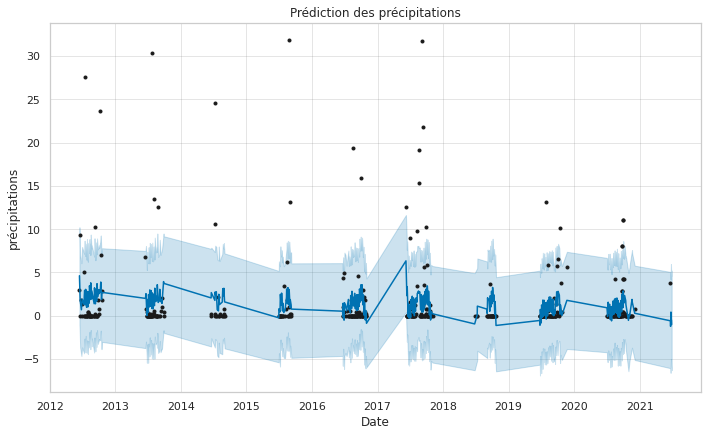

In [45]:
m5.plot(predictions5)
plt.title("Prédiction des précipitations")
plt.xlabel("Date")
plt.ylabel("précipitations")
plt.show()

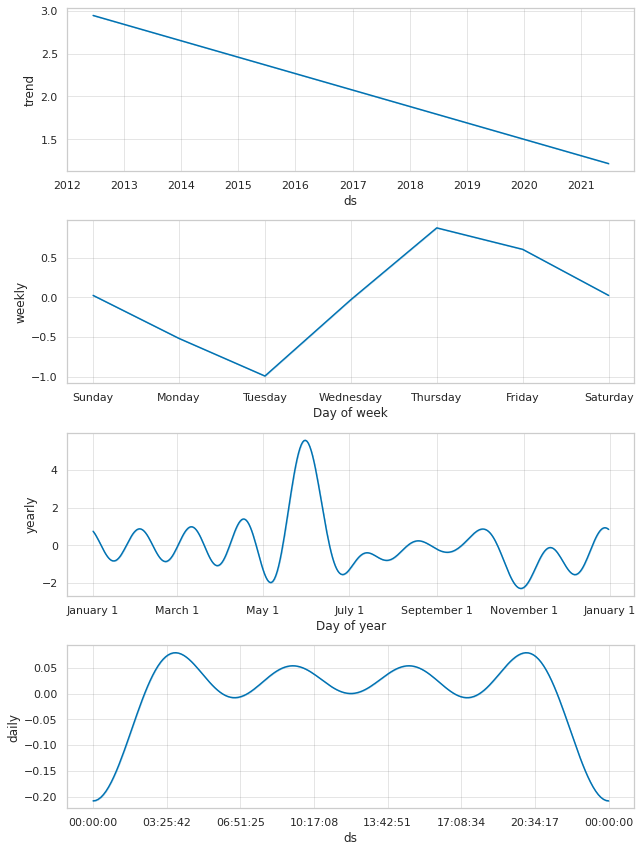

In [46]:
m5.plot_components(predictions5)
plt.show()

In [47]:
#ensoleillement

dfE = Pop[["Date","Ensoleillement en min"]]

dfE['ds'] = pd.to_datetime(dfE['Date'])
dfE['y'] = dfE['Ensoleillement en min']
dfE = dfE.drop(["Date","Ensoleillement en min"], axis=1)
dfE

,ds,y
354,2012-01-08,445
333,2012-01-10,536
332,2012-02-10,121
353,2012-03-08,330
342,2012-04-09,672
...,...,...
388,2020-11-09,552
19,2020-11-09,552
373,2020-11-19,352
372,2020-11-20,297


In [48]:
m6 = Prophet(daily_seasonality=True)
m6.fit(dfE)

future6 = m6.make_future_dataframe(periods=7, freq='D')
predictions6=m6.predict(future6)

predictions6[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
400,2021-06-22,578.860623,246.049713,902.925056
401,2021-06-23,577.989268,270.683814,903.194537
402,2021-06-24,519.106653,190.720928,837.779924
403,2021-06-25,483.341494,165.132078,815.969118
404,2021-06-26,607.245217,291.673519,917.979744
405,2021-06-27,439.553676,109.368524,762.446136
406,2021-06-28,526.113999,196.248708,848.462202


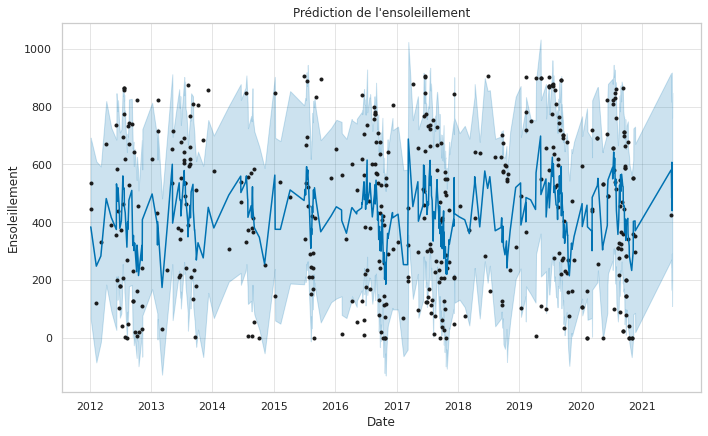

In [49]:
m6.plot(predictions6)
plt.title("Prédiction de l'ensoleillement")
plt.xlabel("Date")
plt.ylabel("Ensoleillement")
plt.show()

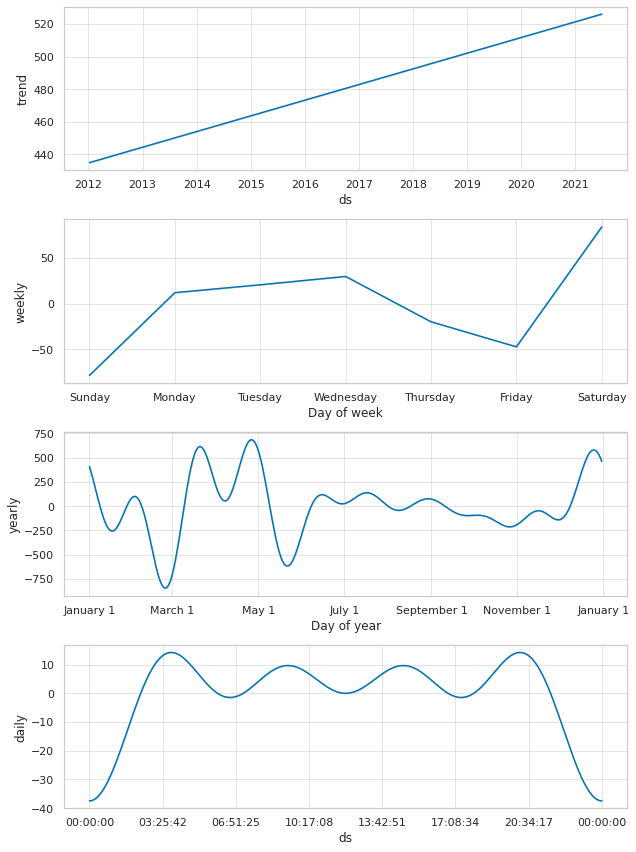

In [50]:
m6.plot_components(predictions6)
plt.show()

In [51]:
#vitesse du vent

dfV = Pop[["Date","Rafales (vitesse du vent) en km/h"]]

dfV['ds'] = pd.to_datetime(dfV['Date'],infer_datetime_format=True, dayfirst= True)
dfV['y'] = dfV['Rafales (vitesse du vent) en km/h']
dfV = dfV.drop(["Date","Rafales (vitesse du vent) en km/h"], axis=1)
dfV

,ds,y
354,2012-08-01,44.4
333,2012-10-01,40.7
332,2012-10-02,38.9
353,2012-08-03,42.8
342,2012-09-04,37.0
...,...,...
388,2020-09-11,29.5
19,2020-09-11,29.5
373,2020-11-19,61.2
372,2020-11-20,26.3


In [52]:
m7 = Prophet(daily_seasonality=True)
m7.fit(dfV)

future7 = m7.make_future_dataframe(periods=7, freq='D')
predictions7=m7.predict(future7)

predictions7[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
400,2021-06-22,44.172208,28.669195,58.871328
401,2021-06-23,43.818789,28.618711,59.160047
402,2021-06-24,46.208552,30.805662,61.598098
403,2021-06-25,44.229409,29.181393,60.257231
404,2021-06-26,45.399866,30.690409,61.269852
405,2021-06-27,45.475958,29.485924,60.679702
406,2021-06-28,44.841416,30.174172,60.117162


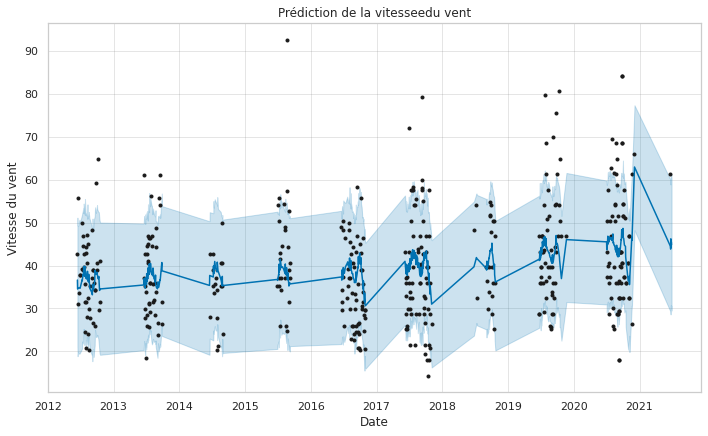

In [53]:
m7.plot(predictions7)
plt.title("Prédiction de la vitesseedu vent")
plt.xlabel("Date")
plt.ylabel("Vitesse du vent")
plt.show()

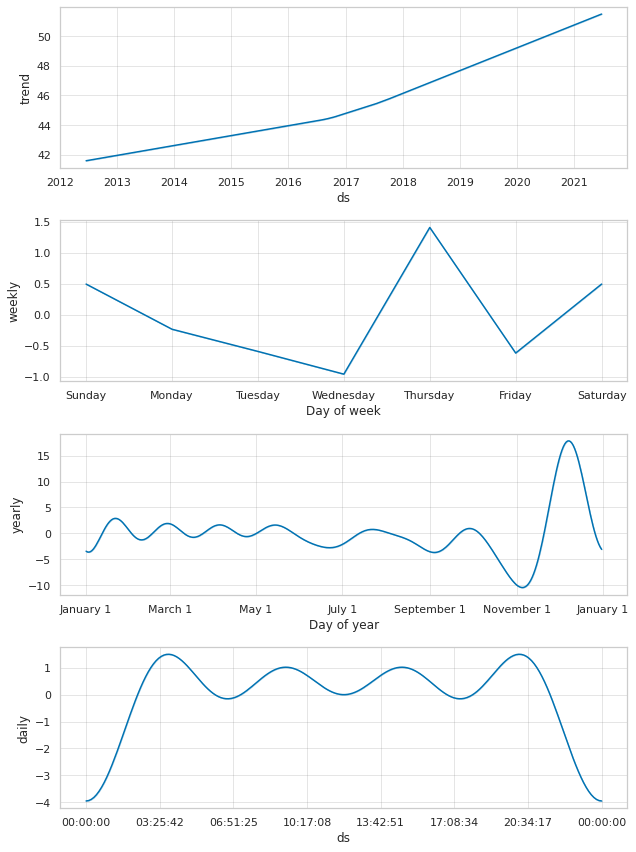

In [54]:
m7.plot_components(predictions7)
plt.show()

**Tableau récapitulatif des prédictions**

In [55]:
RTS={'Prix au kilo des tomates dans 7 jours':[1.761, 1.746, 1.714, 1.711, 1.756, 1.704, 1.668],
     'Production de tomates dans 7 jours' :[0.397, 0.133, 0.240, 0.073, 0.203, 0.049, 0.265],
     'Température minimale dans 7 jours': [14.5, 15.6, 14.5, 14.8, 12.9, 12.8, 13.3],
     'Température maximale dans 7 jours':[27.8, 28.5, 26.3, 25.5, 25.9, 24.4, 26.3],
     'Précipitations dans 7 jours':[0.7, 0.6, 0.8, 1.7, 0.4, 0.6, 0.1],
     'Ensoleillement dans 7 jours':[579, 578, 519, 483, 607, 440, 526],
     'Vitesse du vent dans 7 jours':[43.9, 44.8, 46, 47.3, 44.4, 45.9, 45.5]}
D = pd.DataFrame(RTS, index=['2021-06-22','2021-06-23','2021-06-24','2021-06-25','2021-06-26','2021-06-27','2021-06-28'])
D

,Prix au kilo des tomates dans 7 jours,Production de tomates dans 7 jours,Température minimale dans 7 jours,Température maximale dans 7 jours,Précipitations dans 7 jours,Ensoleillement dans 7 jours,Vitesse du vent dans 7 jours
2021-06-22,1.761,0.397,14.5,27.8,0.7,579,43.9
2021-06-23,1.746,0.133,15.6,28.5,0.6,578,44.8
2021-06-24,1.714,0.240,14.5,26.3,0.8,519,46.0
2021-06-25,1.711,0.073,14.8,25.5,1.7,483,47.3
2021-06-26,1.756,0.203,12.9,25.9,0.4,607,44.4
2021-06-27,1.704,0.049,12.8,24.4,0.6,440,45.9
2021-06-28,1.668,0.265,13.3,26.3,0.1,526,45.5


**Enregistrement du modèle pour la production**

In [56]:
import pickle

filename = 'modèle_prophet_Production.pkl'
pickle.dump(m2, open(filename, 'wb'))

In [57]:
modèle2 = pickle.load(open(filename, 'rb'))
modèle2